## Test experiments on DG simulations with non-dimensional inputs and outputs

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [3]:
import wandb

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2024-10-29 11:33:28.266941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 11:33:28.282547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 11:33:28.286969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We will run a few experiment configs. All with non-dim outputs. The goal is to compare the impact of inputs.

1. Inputs: norm vel gradients, thickness gradients
2. Inputs: norm vel gradients, interface slope
3. Inputs: norm vel gradients, thickness gradients, inteface slopes

In [5]:
experiment_config= {'experiment_name': 'DG_3_non_dim_24_24', # Any sort of name will work here 
                    'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':3, 
                    
                    'input_channels' : ['dudx_widened_nondim',  
                                        'dvdx_widened_nondim', 
                                        'dudy_widened_nondim',
                                        'dvdy_widened_nondim',
                                        'dhdx_widened',
                                        'dhdy_widened'],
                    
                    'output_channels' : ['uphp_nondim',
                                         'vphp_nondim'],
                    
                    'coeff_channels'  : [], 
                    
                    'extra_channels': ['filter_scale',
                                       'mag_nabla_u_widened',
                                       'uphp',
                                       'vphp'],

                    'all_time_range': slice(0, 1400), 
                    'train_time_range': slice(0, 1200),
                    'test_time_range' : slice(-100, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 
                   
                    'network_shape': [24, 24, 2],
                    'single_layer_mask': True}

experiment_config['all_ml_variables'] = (experiment_config['input_channels'] + 
                                           experiment_config['output_channels'] +
                                           experiment_config['coeff_channels']+ 
                                           experiment_config['extra_channels'])

#experiment_config['num_inputs'] = (len(experiment_config['input_channels']))*experiment_config['window_size']**2 

# experiment_config['exp_ckpt_save_dir'] = ('/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/non_dim_models/' + 
#                                           '_'.join(experiment_config['simulation_names']) + 
#                                           '_' + str(experiment_config['window_size']) )

experiment_config['exp_ckpt_save_dir'] = ('/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/non_dim_models/' + 
                                          experiment_config['experiment_name'] ) 

In [6]:
experiment_config['exp_ckpt_save_dir']

'/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/non_dim_models/DG_3_non_dim_24_24'

In [8]:
wandb.init(
    project='non_dimensional_models', 
    config = experiment_config)

AttributeError: module 'wandb' has no attribute 'init'

In [8]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names='DG',#experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'],
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask=experiment_config['single_layer_mask'])

In [9]:
DT.simulation_data

DataTree('None', parent=None)
├── DataTree('50')
│       Dimensions:                      (Time: 1400, xh: 200, yh: 220, zl: 2, Xn: 3,
│                                         Yn: 3, zi: 3)
│       Coordinates:
│         * Time                         (Time) object 11kB 0001-01-11 00:00:00 ... 0...
│         * xh                           (xh) float64 2kB 0.055 0.165 ... 21.84 21.95
│         * yh                           (yh) float64 2kB 30.05 30.14 ... 49.86 49.95
│         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
│       Dimensions without coordinates: Xn, Yn
│       Data variables: (12/65)
│           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 9GB dask.array<chunksize=(36, 2, 219, 199, 3, 3), meta=np.ndarray>
│           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 9GB dask.array<chunksize=(36, 2, 219, 199, 3, 3), meta=np.ndarray>
│           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 9GB dask.array<chunksize=(36, 2, 219, 199, 3, 3), meta=np.ndarray>
│           dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 9GB dask.array<chunksize=(36, 2, 219, 199, 3, 3), meta=np.ndarray>
│           dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 9GB dask.array<chunksize=(36, 2, 219, 199, 3, 3), meta=np.ndarray>
│           dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 9GB dask.array<chunksize=(36, 2, 219, 199, 3, 3), meta=np.ndarray>
│           ...                           ...
│           uphp_rotated_nondim          (Time, zl, yh, xh) float64 986MB dask.array<chunksize=(36, 2, 219, 199), meta=np.ndarray>
│           vphp_rotated_nondim          (Time, zl, yh, xh) float64 986MB dask.array<chunksize=(36, 2, 219, 199), meta=np.ndarray>
│           uphp_nondim                  (Time, zl, yh, xh) float64 986MB dask.array<chunksize=(36, 2, 219, 199), meta=np.ndarray>
│           vphp_nondim                  (Time, zl, yh, xh) float64 986MB dask.array<chunksize=(36, 2, 219, 199), meta=np.ndarray>
│           Rd_nondim                    (Time, yh, xh) float64 493MB dask.array<chunksize=(36, 220, 200), meta=np.ndarray>
│           single_layer_mask            (Time, yh, xh) float64 493MB dask.array<chunksize=(36, 220, 200), meta=np.ndarray>
│       Attributes:
│           simulation_name:  DG
│           filter_scale:     50
│           source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
│           description:      Dataset for DG experiment at 50 km resolution
├── DataTree('100')
│       Dimensions:                      (Time: 1400, xh: 100, yh: 110, zl: 2, Xn: 3,
│                                         Yn: 3, zi: 3)
│       Coordinates:
│         * Time                         (Time) object 11kB 0001-01-11 00:00:00 ... 0...
│         * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
│         * yh                           (yh) float64 880B 30.09 30.27 ... 49.73 49.91
│         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
│       Dimensions without coordinates: Xn, Yn
│       Data variables: (12/65)
│           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(36, 2, 109, 99, 3, 3), meta=np.ndarray>
│           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(36, 2, 109, 99, 3, 3), meta=np.ndarray>
│           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(36, 2, 109, 99, 3, 3), meta=np.ndarray>
│           dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(36, 2, 109, 99, 3, 3), meta=np.ndarray>
│           dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksi

In [18]:
DT.generate_h_mask()

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
<xarray.Dataset> Size: 12GB
Dimensions:  (Time: 1400, zi: 3, yh: 220, xh: 200, zl: 2)
Coordinates:
  * Time     (Time) object 11kB 0001-01-11 00:00:00 ... 0039-05-02 00:00:00
  * xh       (xh) float64 2kB 0.055 0.165 0.275 0.385 ... 21.73 21.84 21.95
  * yh       (yh) float64 2kB 30.05 30.14 30.23 30.32 ... 49.77 49.86 49.95
  * zi       (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
  * zl       (zl) float64 16B 1.035e+03 1.036e+03
Data variables: (12/14)
    dedx     (Time, zi, yh, xh) float64 1GB dask.array<chunksize=(36, 3, 220, 200), meta=np.ndarray>
    dedy     (Time, zi, yh, xh) float64 1GB dask.array<chunksize=(36, 3, 220, 200), meta=np.ndarray>
    dhdx     (Time, zl, yh, xh) float64 986MB dask.array<chunksize=(36, 2, 220, 200), meta=np.ndarray>
    dhdy     (Time, zl, yh, xh) float64 986MB dask.array<chunksize=(36, 2, 220, 200), meta=np.ndarray>
    dudx     (Time, zl, yh, xh) float64 986MB dask.array<chun

### ML part

In [11]:
ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 3.40992 gb into memory.
load took: 52.5044 seconds
Will load : 0.28416 gb into memory.
load took: 6.0175 seconds


In [12]:
batch_xr = ML_DT_train.ml_batches[0]

In [13]:
batch_xr.std()

<xarray.Dataset> Size: 88B
Dimensions:              ()
Data variables:
    dudx_widened_nondim  float64 8B 0.1209
    dvdx_widened_nondim  float64 8B 0.2262
    dudy_widened_nondim  float64 8B 0.1752
    dvdy_widened_nondim  float64 8B 0.1205
    dhdx_widened         float64 8B 0.0005558
    dhdy_widened         float64 8B 0.0005304
    uphp_nondim          float64 8B 8.256e-06
    vphp_nondim          float64 8B 1.017e-05
    filter_scale         float64 8B 1.297e+05
    mag_nabla_u_widened  float64 8B 3.24e-06
    uphp                 float32 4B 0.4148
    vphp                 float32 4B 0.6106

In [8]:
normalize_data_dic={
    'dudx_widened_nondim': ([], 1.),  # scalar value
    'dvdx_widened_nondim': ([], 1.),
    'dudy_widened_nondim': ([], 1.),
    'dvdy_widened_nondim': ([], 1.),
    'dhdx_widened': ([], 1e-3),
    'dhdy_widened': ([], 1e-3),
    'Rd_nondim': ([], 1.),
    'uphp_nondim': ([], 1e-5),
    'vphp_nondim': ([], 1e-5)}

ds_norm = xr.Dataset(normalize_data_dic)

In [13]:
# Define the variables and assign normalizations 

# normalize_data_dic = {
#     'dudx': ([], 1e-6),  # scalar value
#     'dvdx': ([], 1e-6),
#     'dudy': ([], 1e-6),
#     'dvdy': ([], 1e-6),
#     'dhdx': ([], 1e-3),
#     'dhdy': ([], 1e-3),
#     'dedx_middle': ([], 1e-3),
#     'dedy_middle': ([], 1e-3),
#     'filter_scale': ([], 140e3),
#     'uphp': ([], 4.),
#     'vphp': ([], 4.),

#     'dudx_nondim': ([], 1.),  # scalar value
#     'dvdx_nondim': ([], 1.),
#     'dudy_nondim': ([], 1.),
#     'dvdy_nondim': ([], 1.),

#     'dudx_widened_nondim': ([], 1.),  # scalar value
#     'dvdx_widened_nondim': ([], 1.),
#     'dudy_widened_nondim': ([], 1.),
#     'dvdy_widened_nondim': ([], 1.),
    
#     'uphp_nondim': ([], 1e-5),
#     'vphp_nondim': ([], 1e-5),

#     'dudx_widened': ([], 1e-6),  # scalar value
#     'dvdx_widened': ([], 1e-6),
#     'dudy_widened': ([], 1e-6),
#     'dvdy_widened': ([], 1e-6),
#     'dhdx_widened': ([], 1e-3),
#     'dhdy_widened': ([], 1e-3),
#     'dedx_middle_widened': ([], 1e-3),
#     'dedy_middle_widened': ([], 1e-3),
#     'dhdx_widened_rotated': ([], 1e-3),
#     'dhdy_widened_rotated': ([], 1e-3),
    
#     'dudx_widened_rotated_nondim': ([], 1e-1),  # scalar value
#     'dvdx_widened_rotated_nondim': ([], 1e-1),
#     'dudy_widened_rotated_nondim': ([], 1e-1),
#     'dvdy_widened_rotated_nondim': ([], 1e-1),
#     'dhdx_widened_rotated_nondim': ([], 1e-1),
#     'dhdy_widened_rotated_nondim': ([], 1e-1),
#     'uphp_rotated_nondim': ([], 1e-5),
#     'vphp_rotated_nondim': ([], 1e-5),
# }

In [14]:
wandb.config.update({"normalization_constants": normalize_data_dic})

In [14]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [15]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    print("Output (Xp) batch shape:", batch_out['Xp'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (105433, 54)
Output (y) batch shape: (105433, 2)
Output (Xp) batch shape: (105433, 2)


In [16]:
num_in = batch_out['X'].shape[-1]
num_in

54

In [17]:
experiment_config['num_inputs'] = num_in

In [19]:
wandb.config.update({"num_in": experiment_config['num_inputs']})

In [20]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [21]:
ANN_model.count_parameters()

1970


In [22]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model)

In [23]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=101, print_freq=2, use_wandb=True)

At epoch 1. Train loss :  0.5712508156492904 , Test loss: 0.40622429847717284
At epoch 3. Train loss :  0.30981172339336294 , Test loss: 0.3140078842639923
At epoch 5. Train loss :  0.2797687142281919 , Test loss: 0.2899405360221863
At epoch 7. Train loss :  0.2626140077371855 , Test loss: 0.27405205368995667
At epoch 9. Train loss :  0.25024750466282303 , Test loss: 0.26303973197937014
At epoch 11. Train loss :  0.24202833385080905 , Test loss: 0.25422041714191435
At epoch 13. Train loss :  0.23598646271873164 , Test loss: 0.24860428869724274
At epoch 15. Train loss :  0.23173925240297574 , Test loss: 0.24504012763500213
At epoch 17. Train loss :  0.22871358974559888 , Test loss: 0.2424060434103012
At epoch 19. Train loss :  0.22658880538231618 , Test loss: 0.2407553791999817
At epoch 21. Train loss :  0.22476560884230845 , Test loss: 0.23909204304218293
At epoch 23. Train loss :  0.22320274203210264 , Test loss: 0.23818471431732177
At epoch 25. Train loss :  0.22196594283387466 , Tes

Clearly and obviously this loss is a function of the normalization that is used. 

In [25]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

### Model evaluation 

In [18]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 extra_channels=experiment_config['extra_channels'],
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1100), 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'])

In [19]:
# Spin up eval pack
test_eval.read_ann_regression_model()
test_eval.read_eval_data()
test_eval.predict()
test_eval.dimensionalize()

Error: You must call wandb.init() before wandb.log()

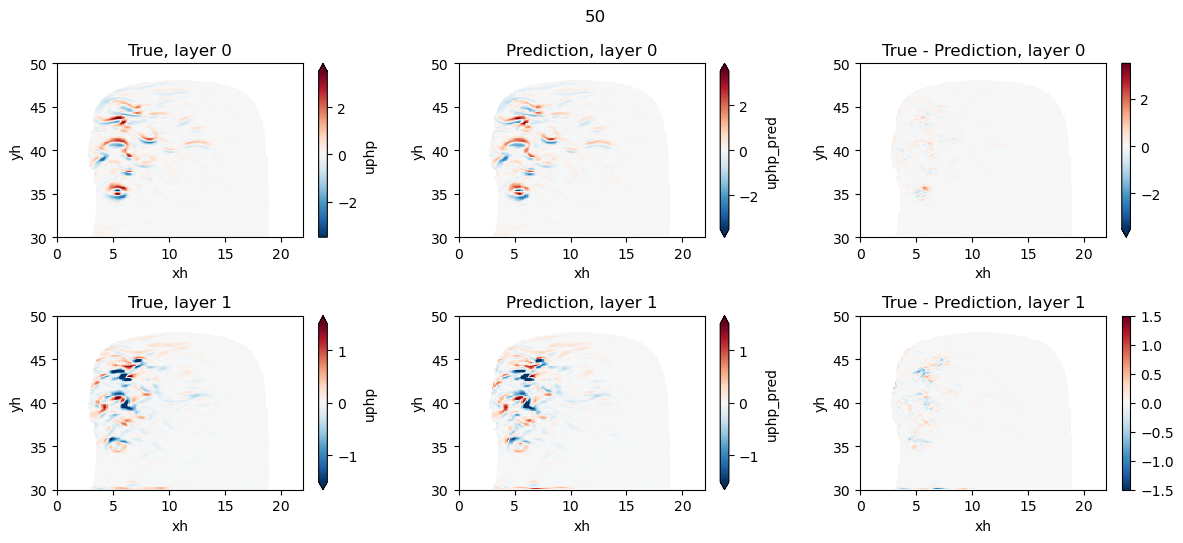

In [20]:
exp = experiment_config['simulation_names'][0]
var = 'uphp'

for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 5.5))
    
    vmin=-3.5
    zl_choice = 0
    
    plt.subplot(231)
    test_eval.eval_datatree.ml_dataset[exp][scale][var].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True, layer 0')
    
    plt.subplot(232)
    test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('Prediction, layer 0')
    
    plt.subplot(233)
    (test_eval.eval_datatree.ml_dataset[exp][scale][var] - 
     test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True - Prediction, layer 0')
    
    vmin=-1.5
    zl_choice = 1
    
    plt.subplot(234)
    test_eval.eval_datatree.ml_dataset[exp][scale][var].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True, layer 1')
    
    plt.subplot(235)
    test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('Prediction, layer 1')
    
    plt.subplot(236)
    (test_eval.eval_datatree.ml_dataset[exp][scale][var] - 
     test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True - Prediction, layer 1')
    
    plt.suptitle(scale)
    plt.tight_layout()
    
    #wandb.Image(plt)
    #wandb.log({'chart':plt})
    
    # buf = io.BytesIO()
    # fig.savefig(buf, format='png')
    # buf.seek(0)
    
    # Log the figure to W&B
    plt_key = var+ '_panels_' + scale
    wandb.log({plt_key: wandb.Image(plt)})

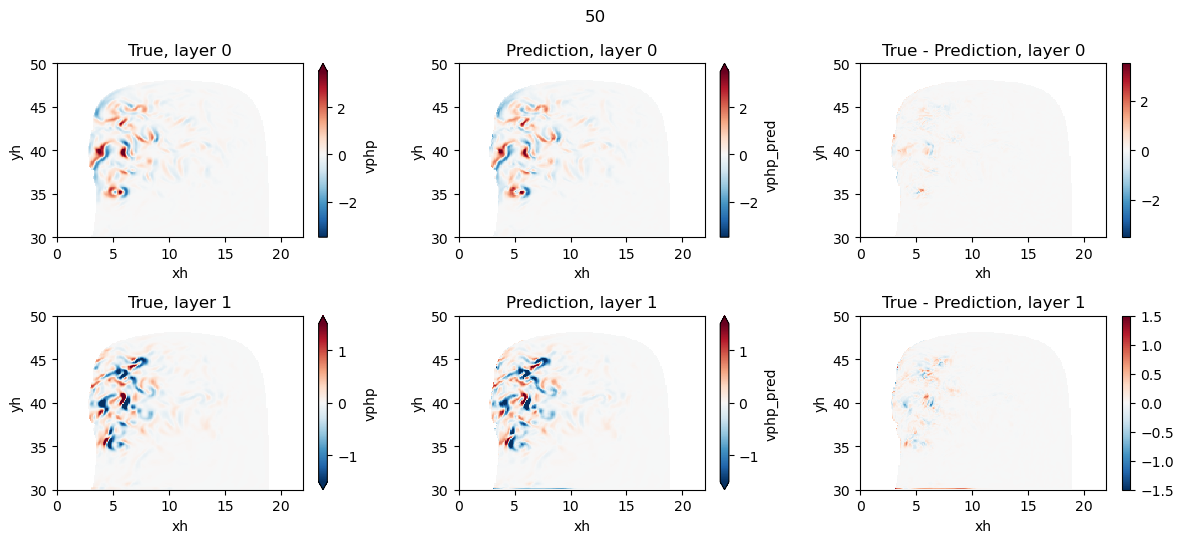

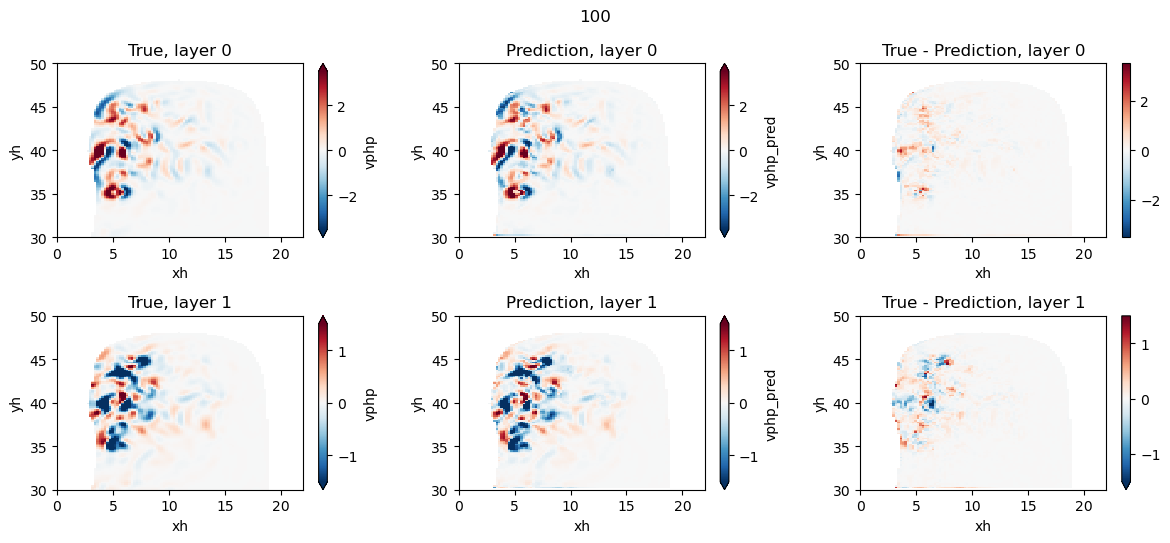

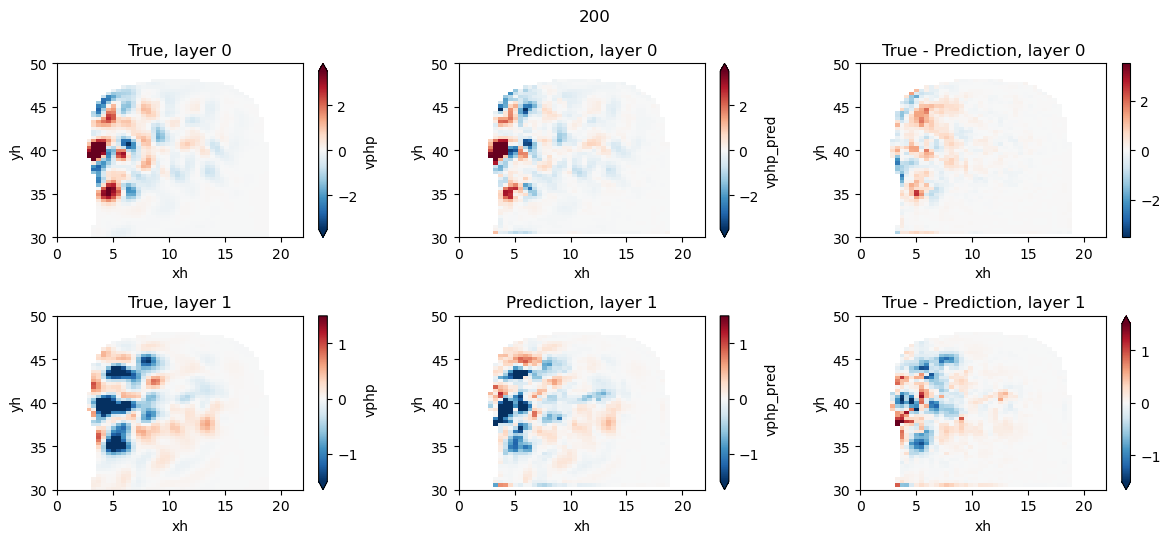

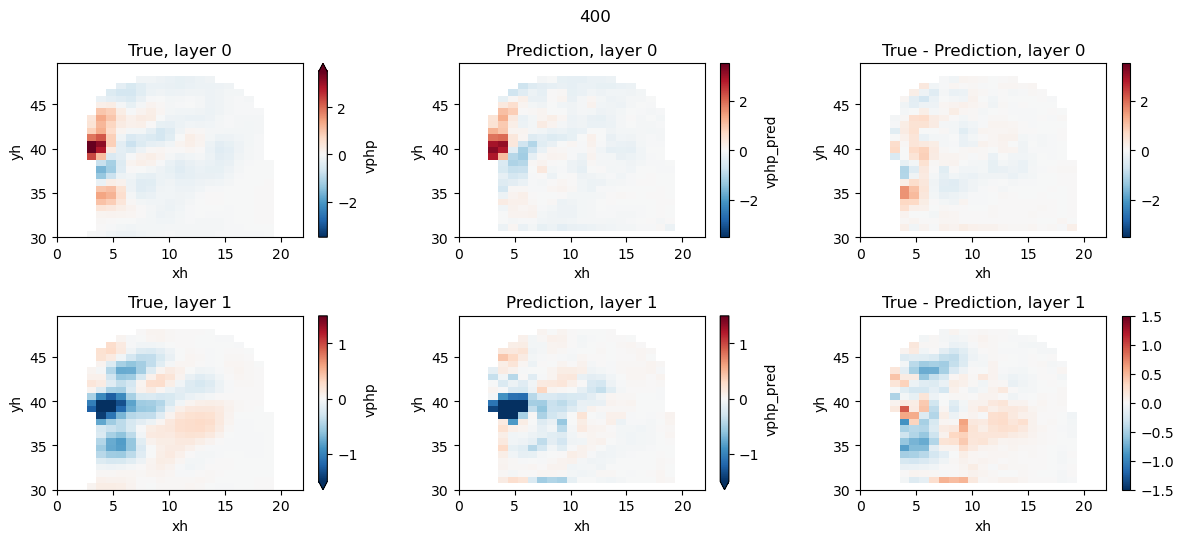

In [29]:
exp = experiment_config['simulation_names'][0]
var = 'vphp'

for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 5.5))
    
    vmin=-3.5
    zl_choice = 0
    
    plt.subplot(231)
    test_eval.eval_datatree.ml_dataset[exp][scale][var].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True, layer 0')
    
    plt.subplot(232)
    test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('Prediction, layer 0')
    
    plt.subplot(233)
    (test_eval.eval_datatree.ml_dataset[exp][scale][var] - 
     test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True - Prediction, layer 0')
    
    vmin=-1.5
    zl_choice = 1
    
    plt.subplot(234)
    test_eval.eval_datatree.ml_dataset[exp][scale][var].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True, layer 1')
    
    plt.subplot(235)
    test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('Prediction, layer 1')
    
    plt.subplot(236)
    (test_eval.eval_datatree.ml_dataset[exp][scale][var] - 
     test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True - Prediction, layer 1')
    
    plt.suptitle(scale)
    plt.tight_layout()
    
    #wandb.Image(plt)
    #wandb.log({'chart':plt})
    
    # buf = io.BytesIO()
    # fig.savefig(buf, format='png')
    # buf.seek(0)
    
    # Log the figure to W&B
    plt_key = var+ '_panels_' + scale
    wandb.log({plt_key: wandb.Image(plt)})

In [30]:
# Pick some region away from boundaries to do that stats 

In [31]:
test_eval.calc_time_hor_space_metrics(var='uphp_nondim', descriptor='all_space_time', dims=['Time','xh','yh','zl'])
test_eval.calc_time_hor_space_metrics(var='vphp_nondim', descriptor='all_space_time', dims=['Time','xh','yh','zl'])

test_eval.calc_time_hor_space_metrics(var='uphp_nondim', descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval.calc_time_hor_space_metrics(var='vphp_nondim', descriptor='layer_wise', dims=['Time','xh','yh'])

In [32]:
test_eval.calc_time_hor_space_metrics(var='uphp', descriptor='all_space_time', dims=['Time','xh','yh','zl'])
test_eval.calc_time_hor_space_metrics(var='vphp', descriptor='all_space_time', dims=['Time','xh','yh','zl'])

test_eval.calc_time_hor_space_metrics(var='uphp', descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval.calc_time_hor_space_metrics(var='vphp', descriptor='layer_wise', dims=['Time','xh','yh'])

test_eval.calc_time_hor_space_metrics(var='uphp', descriptor='time', dims=['Time'])
test_eval.calc_time_hor_space_metrics(var='vphp', descriptor='time', dims=['Time'])

In [33]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_layer_wise.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.75088707 0.92280344]
DG 50km, R2 for vphp is (layer:[0,1])[0.95245311 0.94025073]
DG 100km, R2 for uphp is (layer:[0,1])[0.83796879 0.86705213]
DG 100km, R2 for vphp is (layer:[0,1])[0.92088743 0.88569051]
DG 200km, R2 for uphp is (layer:[0,1])[0.74606479 0.66187967]
DG 200km, R2 for vphp is (layer:[0,1])[0.78651119 0.75898505]
DG 400km, R2 for uphp is (layer:[0,1])[0.66462556 0.47008208]
DG 400km, R2 for vphp is (layer:[0,1])[0.59138687 0.43633441]


In [34]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', corr for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_layer_wise.values))
        print(exp+' '+scale+', corr for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_layer_wise.values))

DG 50, corr for uphp is (layer:[0,1])[0.88626238 0.96094464]
DG 50, corr for vphp is (layer:[0,1])[0.97643843 0.96990151]
DG 100, corr for uphp is (layer:[0,1])[0.92544292 0.93144092]
DG 100, corr for vphp is (layer:[0,1])[0.96016133 0.94203485]
DG 200, corr for uphp is (layer:[0,1])[0.87001022 0.81616292]
DG 200, corr for vphp is (layer:[0,1])[0.89464654 0.87385792]
DG 400, corr for uphp is (layer:[0,1])[0.82576452 0.67119426]
DG 400, corr for vphp is (layer:[0,1])[0.78125644 0.67882889]


In [35]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', MSE for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_mse_layer_wise.values))
        print(exp+' '+scale+', MSE for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_mse_layer_wise.values))

DG 50, MSE for uphp is (layer:[0,1])[0.02316987 0.00252831]
DG 50, MSE for vphp is (layer:[0,1])[0.00883127 0.00379876]
DG 100, MSE for uphp is (layer:[0,1])[0.05633105 0.01158836]
DG 100, MSE for vphp is (layer:[0,1])[0.05965684 0.02351287]
DG 200, MSE for uphp is (layer:[0,1])[0.10961487 0.03176994]
DG 200, MSE for vphp is (layer:[0,1])[0.18689084 0.06631842]
DG 400, MSE for uphp is (layer:[0,1])[0.07368974 0.02765856]
DG 400, MSE for vphp is (layer:[0,1])[0.15715126 0.08876608]


<Figure size 1200x550 with 0 Axes>

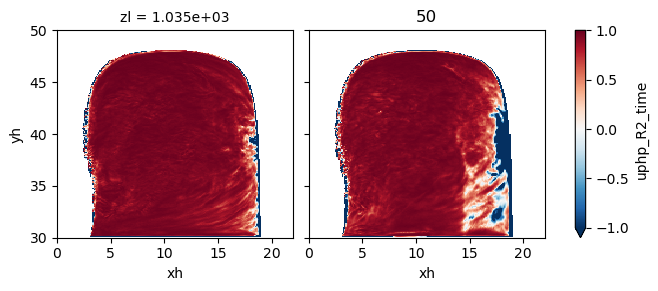

<Figure size 1200x550 with 0 Axes>

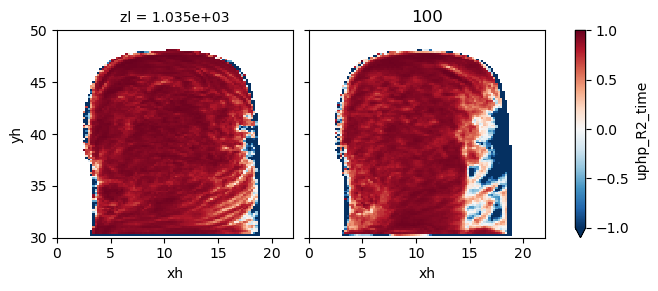

<Figure size 1200x550 with 0 Axes>

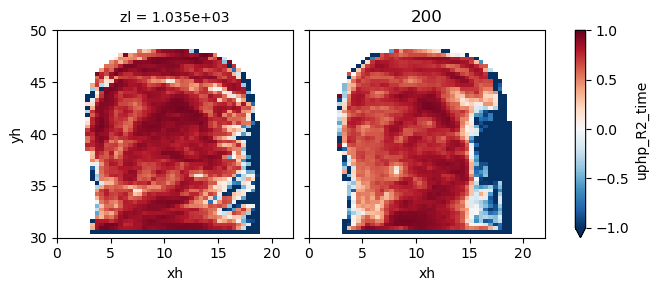

<Figure size 1200x550 with 0 Axes>

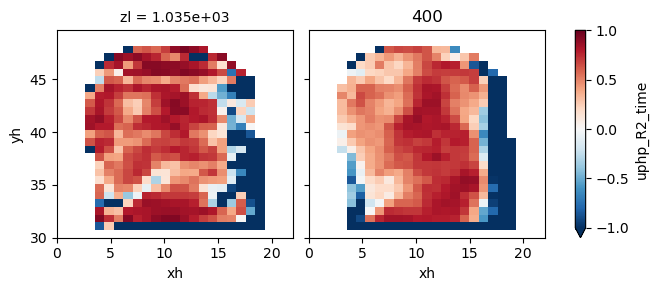

In [36]:
for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 5.5))

    test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_time.plot(col='zl', vmax=1)
    plt.title(scale)

<Figure size 1200x550 with 0 Axes>

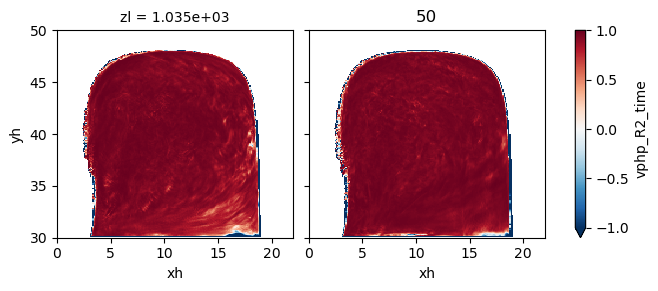

<Figure size 1200x550 with 0 Axes>

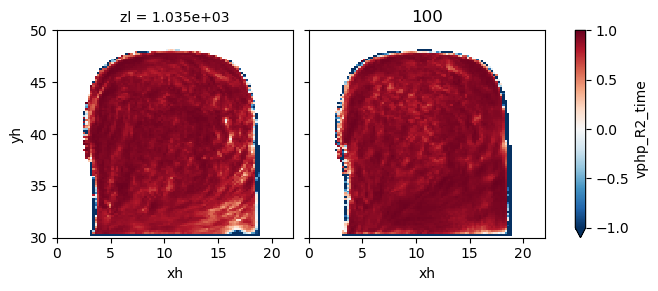

<Figure size 1200x550 with 0 Axes>

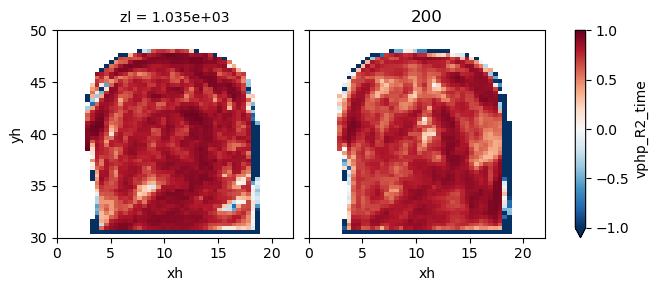

<Figure size 1200x550 with 0 Axes>

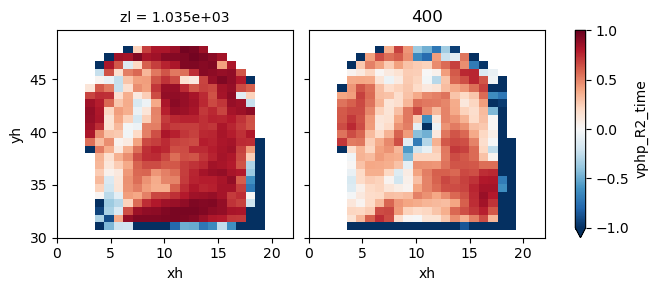

In [37]:
for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 5.5))

    test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_time.plot(col='zl', vmax=1)
    plt.title(scale)

In [38]:
## Write scalewise summary metrics into wandb 

R2_list = np.array([])
corr_list = np.array([])
mse_list = np.array([])

for scale in experiment_config['filter_scales']:

    mse = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_mse_all_space_time.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_mse_all_space_time.values)
    corr = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_all_space_time.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_all_space_time.values)
    R2 = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_all_space_time.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_all_space_time.values)
    
    wandb.run.summary['mse_'+scale] = mse
    wandb.run.summary['R2_'+scale] = R2
    wandb.run.summary['corr_'+scale] = corr
    R2_list = np.append(R2_list, R2)
    corr_list = np.append(corr_list, corr)
    mse_list = np.append(mse_list, mse)

wandb.run.summary['mse'] = np.mean(mse_list)
wandb.run.summary['R2'] = np.mean(R2_list)
wandb.run.summary['corr'] = np.mean(corr_list)

for scale in experiment_config['filter_scales']:
    wandb.run.summary['mse_'+scale+'_layerwise'] = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_mse_layer_wise.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_mse_layer_wise.values)
    wandb.run.summary['R2_'+scale+'_layerwise'] = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_layer_wise.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_layer_wise.values)
    wandb.run.summary['corr_'+scale+'_layerwise'] = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_layer_wise.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_layer_wise.values)
    

In [39]:
wandb.finish()

In [37]:
wandb.finish()

Note that the MSE values here are a bit larger than what we had in loss. This is for 2 reasons (i) There is a factor of 4 in normalization, and (ii) we divided the MSE in training by 2 out of convention. 

In [60]:
Lscale = '400' 

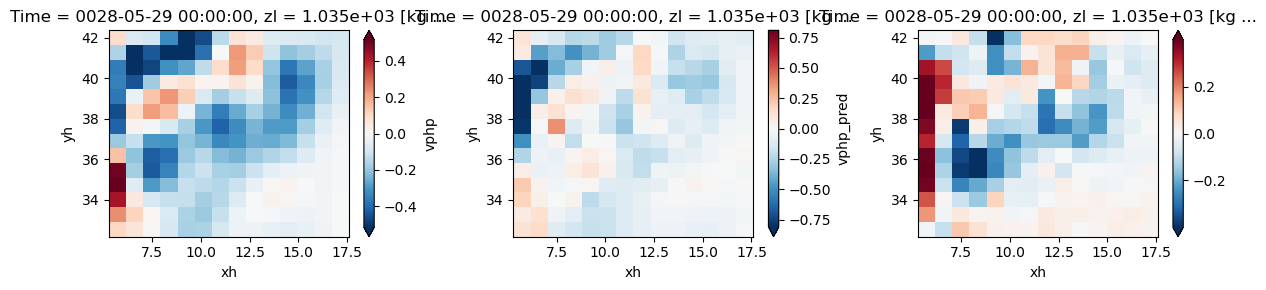

In [61]:
## Spectral calculations 

plt.figure(figsize=(12, 3))

plt.subplot(131)
test_eval.eval_datatree.ml_dataset['DG'][Lscale]['vphp'].isel(Time=0, zl=0).sel(xh=slice(5, 18), yh=slice(32.5, 42.5)).plot(robust=True)

plt.subplot(132)
test_eval.eval_datatree.ml_dataset['DG'][Lscale]['vphp_pred'].isel(Time=0, zl=0).sel(xh=slice(5, 18), yh=slice(32.5, 42.5)).plot(robust=True)

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset['DG'][Lscale]['vphp'] - test_eval.eval_datatree.ml_dataset['DG'][Lscale]['vphp_pred']).isel(Time=0, zl=0).sel(xh=slice(5, 18), yh=slice(32.5, 42.5)).plot(robust=True)

plt.tight_layout()

In [62]:
import xrft

In [63]:
da_u_true = test_eval.eval_datatree.ml_dataset['DG'][Lscale]['uphp'].isel(zl=0).sel(xh=slice(5, 18), yh=slice(32.5, 42.5))
da_v_true = test_eval.eval_datatree.ml_dataset['DG'][Lscale]['vphp'].isel(zl=0).sel(xh=slice(5, 18), yh=slice(32.5, 42.5))

u_ps_true = xrft.power_spectrum(da_u_true, dim='xh', detrend='linear', window=True)
v_ps_true = xrft.power_spectrum(da_v_true, dim='xh', detrend='linear', window=True)

In [64]:
da_u_pred = test_eval.eval_datatree.ml_dataset['DG'][Lscale]['uphp_pred'].isel(zl=0).sel(xh=slice(5, 18), yh=slice(32.5, 42.5))
da_v_pred = test_eval.eval_datatree.ml_dataset['DG'][Lscale]['vphp_pred'].isel(zl=0).sel(xh=slice(5, 18), yh=slice(32.5, 42.5))

u_ps_pred = xrft.power_spectrum(da_u_pred, dim='xh', detrend='linear', window=True)
v_ps_pred = xrft.power_spectrum(da_v_pred, dim='xh', detrend='linear', window=True)


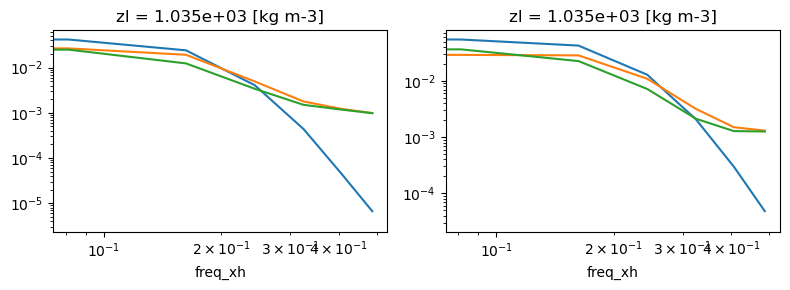

In [65]:
plt.figure(figsize=( 8, 3))

plt.subplot(121)

u_ps_true.mean(['Time','yh']).plot(label='True')
u_ps_pred.mean(['Time','yh']).plot(label='Pred')
np.abs(u_ps_true - u_ps_pred).mean(['Time','yh']).plot(label='|True - Pred|')
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
    
v_ps_true.mean(['Time','yh']).plot(label='True')
v_ps_pred.mean(['Time','yh']).plot(label='Pred')
np.abs(v_ps_true - v_ps_pred).mean(['Time','yh']).plot(label='|True - Pred|')
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()

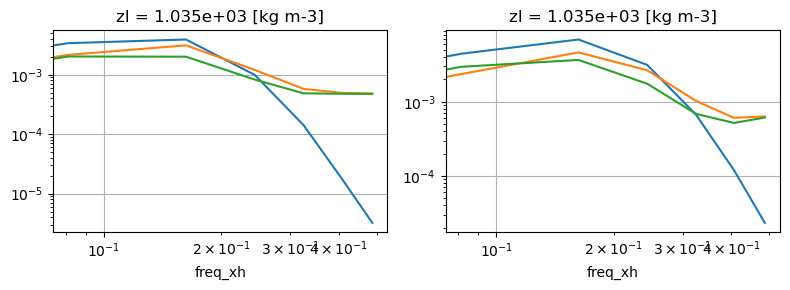

In [66]:
plt.figure(figsize=( 8, 3))

plt.subplot(121)

(u_ps_true.freq_xh * u_ps_true.mean(['Time','yh'])).plot(label='True')
(u_ps_true.freq_xh * u_ps_pred.mean(['Time','yh'])).plot(label='Pred')
(u_ps_true.freq_xh * (np.abs(u_ps_true - u_ps_pred).mean(['Time','yh']))).plot(label='|True - Pred|')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.subplot(122)
    

(u_ps_true.freq_xh * v_ps_true.mean(['Time','yh'])).plot(label='True')
(u_ps_true.freq_xh * v_ps_pred.mean(['Time','yh'])).plot(label='Pred')
(u_ps_true.freq_xh * (np.abs(v_ps_true - v_ps_pred).mean(['Time','yh']))).plot(label='|True - Pred|')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.tight_layout()